# Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize, OrdinalEncoder
from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

from sklearn import set_config
import os

import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, mean_squared_error
from scipy.stats import norm, skew

from colorama import Fore, Style, init
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold, cross_val_score, StratifiedGroupKFold
from xgboost import DMatrix, XGBClassifier
from lightgbm import log_evaluation, early_stopping, LGBMClassifier, Dataset
from catboost import CatBoostClassifier, Pool
from tqdm.notebook import tqdm
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import HyperbandPruner
from functools import partial
from IPython.display import display_html, clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import gc
import re

import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

**Descriptions of Loan Data**

Descriptions for the column names based on the data provided:

* **id**: Unique identifier for each record.
* **person_age**: Age of the individual, categorized into ranges.
* **person_income**: Income of the individual, categorized into income ranges.
* **person_home_ownership**: Homeownership status, which includes categories like 'RENT', 'MORTGAGE', etc.
* **person_emp_length**: Employment length of the individual, categorized into ranges based on years.
* **loan_intent**: The purpose of the loan, with categories such as 'EDUCATION', 'MEDICAL', etc.
* **loan_grade**: The credit grade of the loan, such as 'A', 'B', etc.
* **loan_amnt**: Loan amount, categorized into ranges.
* **loan_int_rate**: Loan interest rate, categorized into percentage ranges.
* **loan_percent_income**: Percentage of the individual’s income that the loan represents, categorized into - ranges.
* **cb_person_default_on_file**: Whether the person has a history of loan default, with values 'true' or 'false'.
* **cb_person_cred_hist_length**: Length of the individual’s credit history, categorized into ranges.
* **loan_status**: with values representing whether the loan status approval( binary values)

The dataset is a about loan applications, including personal, financial, and loan details. It's likely used for predicting whether a person will default on a loan, making it a binary classification problem. The goal is to figure out which applicants are at higher risk of not paying back their loans based on their age, income, employment, loan purpose, credit history, and other related information.

# Setup

In [2]:
class Config:
    
    state = 42
    n_splits = 10
    early_stop = 200
        
    target = 'loan_status'
    train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
    test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
    submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
    train_org = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')
    
    original_data = 'Y'
    outliers = 'N'
    log_trf = 'N'
    scaler_trf = 'Y'
    feature_eng = 'Y'
    missing = 'Y'

# Data Preprocessing

In [3]:
class Preprocessing():
    
    def __init__(self):
        self.train = Config.train
        self.test = Config.test
        self.targets = Config.target

        self.prp_data()
         
    def prp_data(self):
        
        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, Config.train_org], ignore_index=True).drop_duplicates(ignore_index=True)

        self.train = self.train.drop(['id'], axis=1)
        self.test = self.test.drop(['id'], axis=1)
        
        self.cat_features = self.train.drop(self.targets, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        self.num_features = self.train.drop(self.targets, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        
        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        return self
    
    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        return df

# EDA

In [4]:
class EDA(Config, Preprocessing):
    
    def __init__(self):
        super().__init__()
        
        self.data_info()
        self.heatmap()
        self.dist_plots()
        self.cat_feature_plots()
        self.target_pie()
                
    def data_info(self):
        
        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', '#3cb371'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            }, 
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))
                           
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} info\n'+Style.RESET_ALL)               
            display(data.info())
                           
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.targets, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))
            
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} missing values\n'+Style.RESET_ALL)               
            display(data.isna().sum())
        return self
    
    def heatmap(self):
        print(Style.BRIGHT+Fore.GREEN+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.train.select_dtypes(exclude='object').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = 'Greens', annot=True, cbar=False)
        plt.show()
        
    def dist_plots(self):
        print(Style.BRIGHT+Fore.GREEN+f"\nDistribution analysis\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'), 
                        self.test[self.num_features].assign(Source = 'Test'),], 
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (18, len(self.num_features) * 6), 
                                 gridspec_kw = {'hspace': 0.3, 
                                                'wspace': 0.2, 
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            ax = axes[i,0]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                        palette = ['#3cb371', 'r'], ax = ax, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid()

            ax = axes[i,1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['#3cb371', 'r']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()
               
    def cat_feature_plots(self):
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6), 
                                 gridspec_kw = {'hspace': 0.5, 
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):
            
            ax = axes[i,0]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='#3cb371')
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")
            
            ax = axes[i,1]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='r')
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()
        
    def target_pie(self):
        print(Style.BRIGHT+Fore.GREEN+f"\nTarget feature distribution\n")
        targets = self.train[self.targets]
        plt.figure(figsize=(6, 6))
        plt.pie(targets.value_counts(), labels=targets.value_counts().index, autopct='%1.2f%%', colors=sns.color_palette('viridis', len(targets.value_counts())))
        plt.show()        


Train head



,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.000000,EDUCATION,B,6000,11.492188,0.170044,N,14,0
1,22,56000,OWN,6.000000,MEDICAL,C,4000,13.351562,0.070007,N,2,0
2,29,28800,OWN,8.000000,PERSONAL,A,6000,8.898438,0.209961,N,10,0
3,30,70000,RENT,14.000000,VENTURE,B,12000,11.109375,0.170044,N,5,0
4,22,60000,RENT,2.000000,MEDICAL,A,6000,6.921875,0.099976,N,3,0



Train info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91061 entries, 0 to 91060
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91061 non-null  int16  
 1   person_income               91061 non-null  int32  
 2   person_home_ownership       91061 non-null  object 
 3   person_emp_length           90174 non-null  float32
 4   loan_intent                 91061 non-null  object 
 5   loan_grade                  91061 non-null  object 
 6   loan_amnt                   91061 non-null  int32  
 7   loan_int_rate               87966 non-null  float32
 8   loan_percent_income         91061 non-null  float32
 9   cb_person_default_on_file   91061 non-null  object 
 10  cb_person_cred_hist_length  91061 non-null  int8   
 11  loan_status                 91061 non-null  int8   
dtypes: float32(3), int16(1), int32(2), int8(2), object(4)
memory usage: 4.9+ MB

None


Train describe



,mean,std,min,25%,50%,75%,max
person_age,27.621,6.150,20.000,23.000,26.000,30.000,144.000
person_income,64774.321,47922.855,4000.000,40000.000,57000.000,78000.000,6000000.000
person_emp_length,4.732,4.026,0.000,2.000,4.000,7.000,123.000
loan_amnt,9351.508,5848.017,500.000,5000.000,8000.000,12000.000,35000.000
loan_int_rate,10.791,3.109,5.422,7.879,10.953,13.109,23.219
loan_percent_income,0.163,0.097,0.000,0.090,0.140,0.220,0.830
cb_person_cred_hist_length,5.813,4.040,2.000,3.000,4.000,8.000,30.000



Train missing values



person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64


Test head



,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.000000,HOMEIMPROVEMENT,F,25000,15.757812,0.360107,N,2
1,26,96000,MORTGAGE,6.000000,PERSONAL,C,10000,12.679688,0.099976,Y,4
2,26,30000,RENT,5.000000,VENTURE,E,4000,17.187500,0.130005,Y,2
3,33,50000,RENT,4.000000,DEBTCONSOLIDATION,A,7000,8.898438,0.140015,N,7
4,26,102000,MORTGAGE,8.000000,HOMEIMPROVEMENT,D,15000,16.312500,0.150024,Y,4



Test info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int8   
 1   person_income               39098 non-null  int32  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float32
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int32  
 7   loan_int_rate               39098 non-null  float32
 8   loan_percent_income         39098 non-null  float32
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int8   
dtypes: float32(3), int32(2), int8(2), object(4)
memory usage: 2.0+ MB


None


Test describe



,mean,std,min,25%,50%,75%,max
person_age,27.567,6.033,20.000,23.000,26.000,30.000,94.000
person_income,64060.461,37955.829,4000.000,42000.000,58000.000,75885.000,1900000.000
person_emp_length,4.687,3.868,0.000,2.000,4.000,7.000,42.000
loan_amnt,9251.466,5576.255,700.000,5000.000,8000.000,12000.000,35000.000
loan_int_rate,10.661,3.020,5.422,7.879,10.750,12.992,22.109
loan_percent_income,0.160,0.092,0.000,0.090,0.140,0.210,0.730
cb_person_cred_hist_length,5.831,4.072,2.000,3.000,4.000,8.000,30.000



Test missing values



person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


Correlation Heatmap



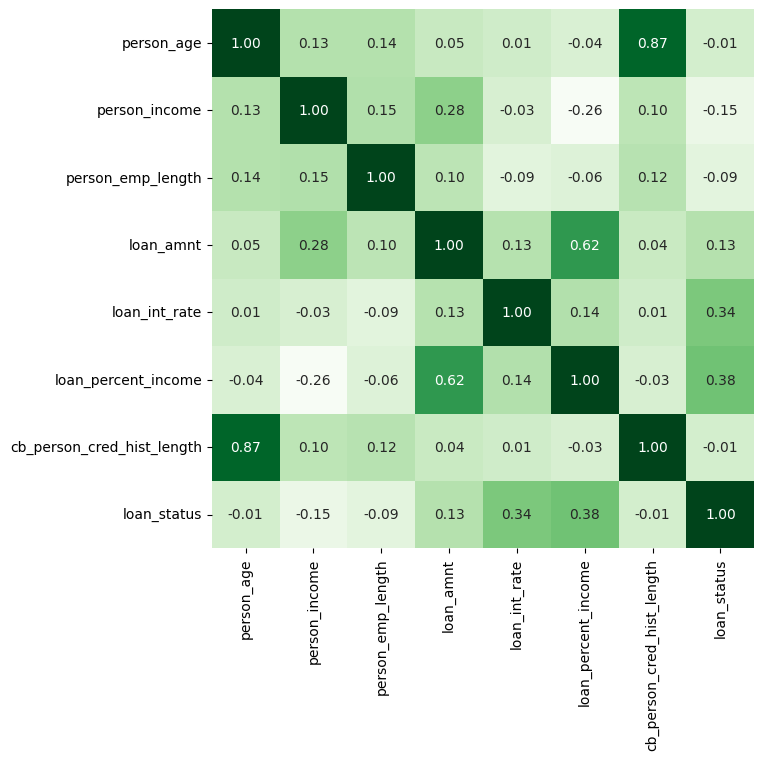


Distribution analysis



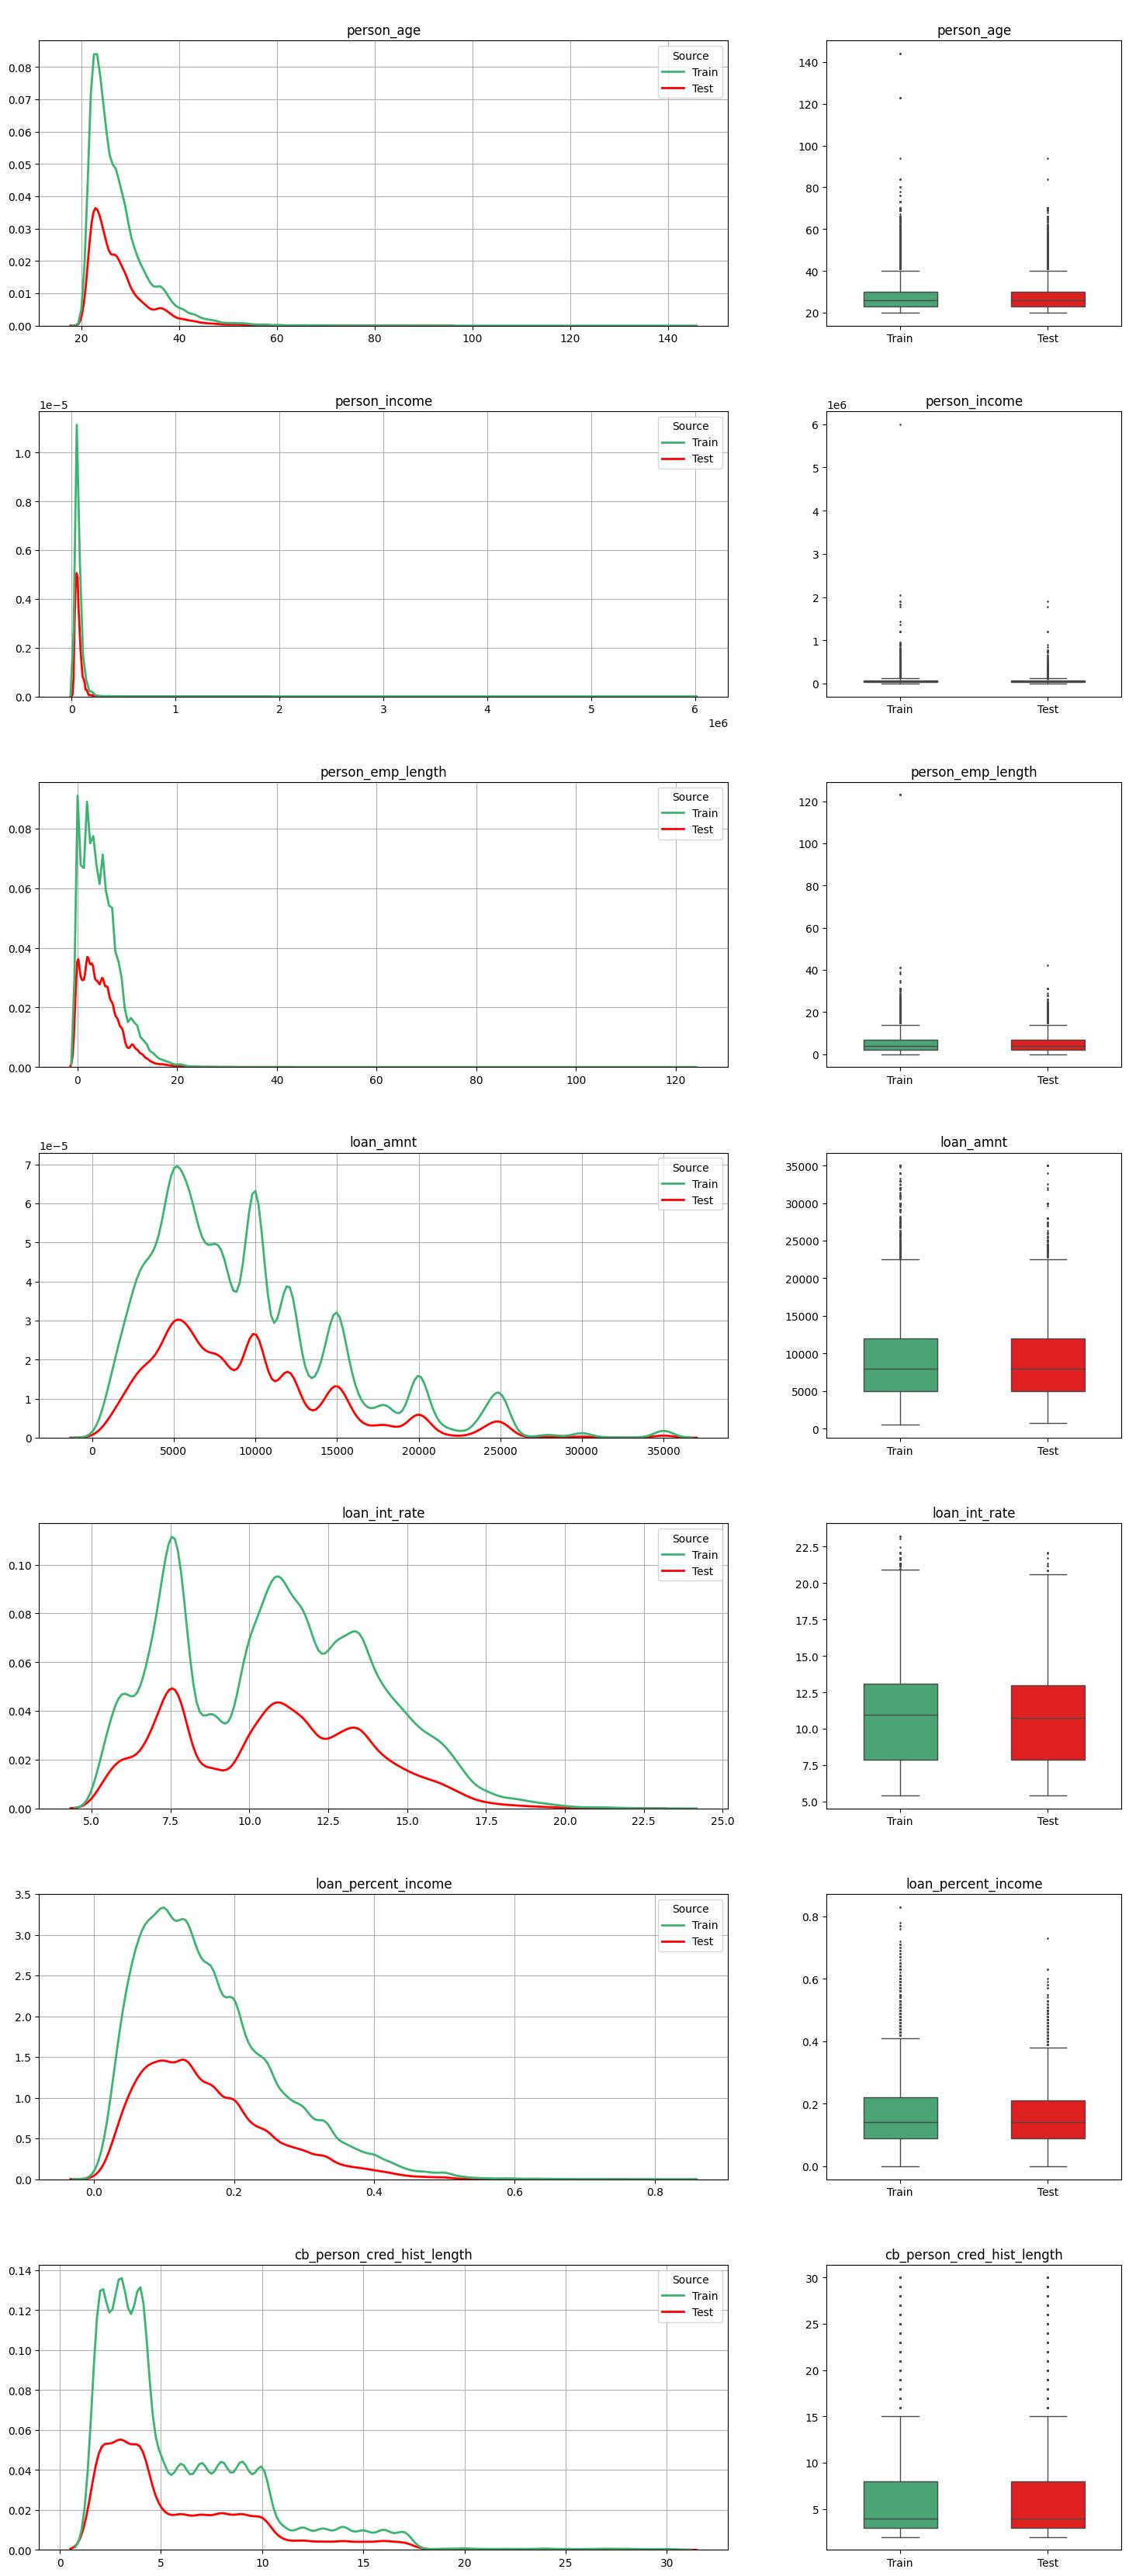

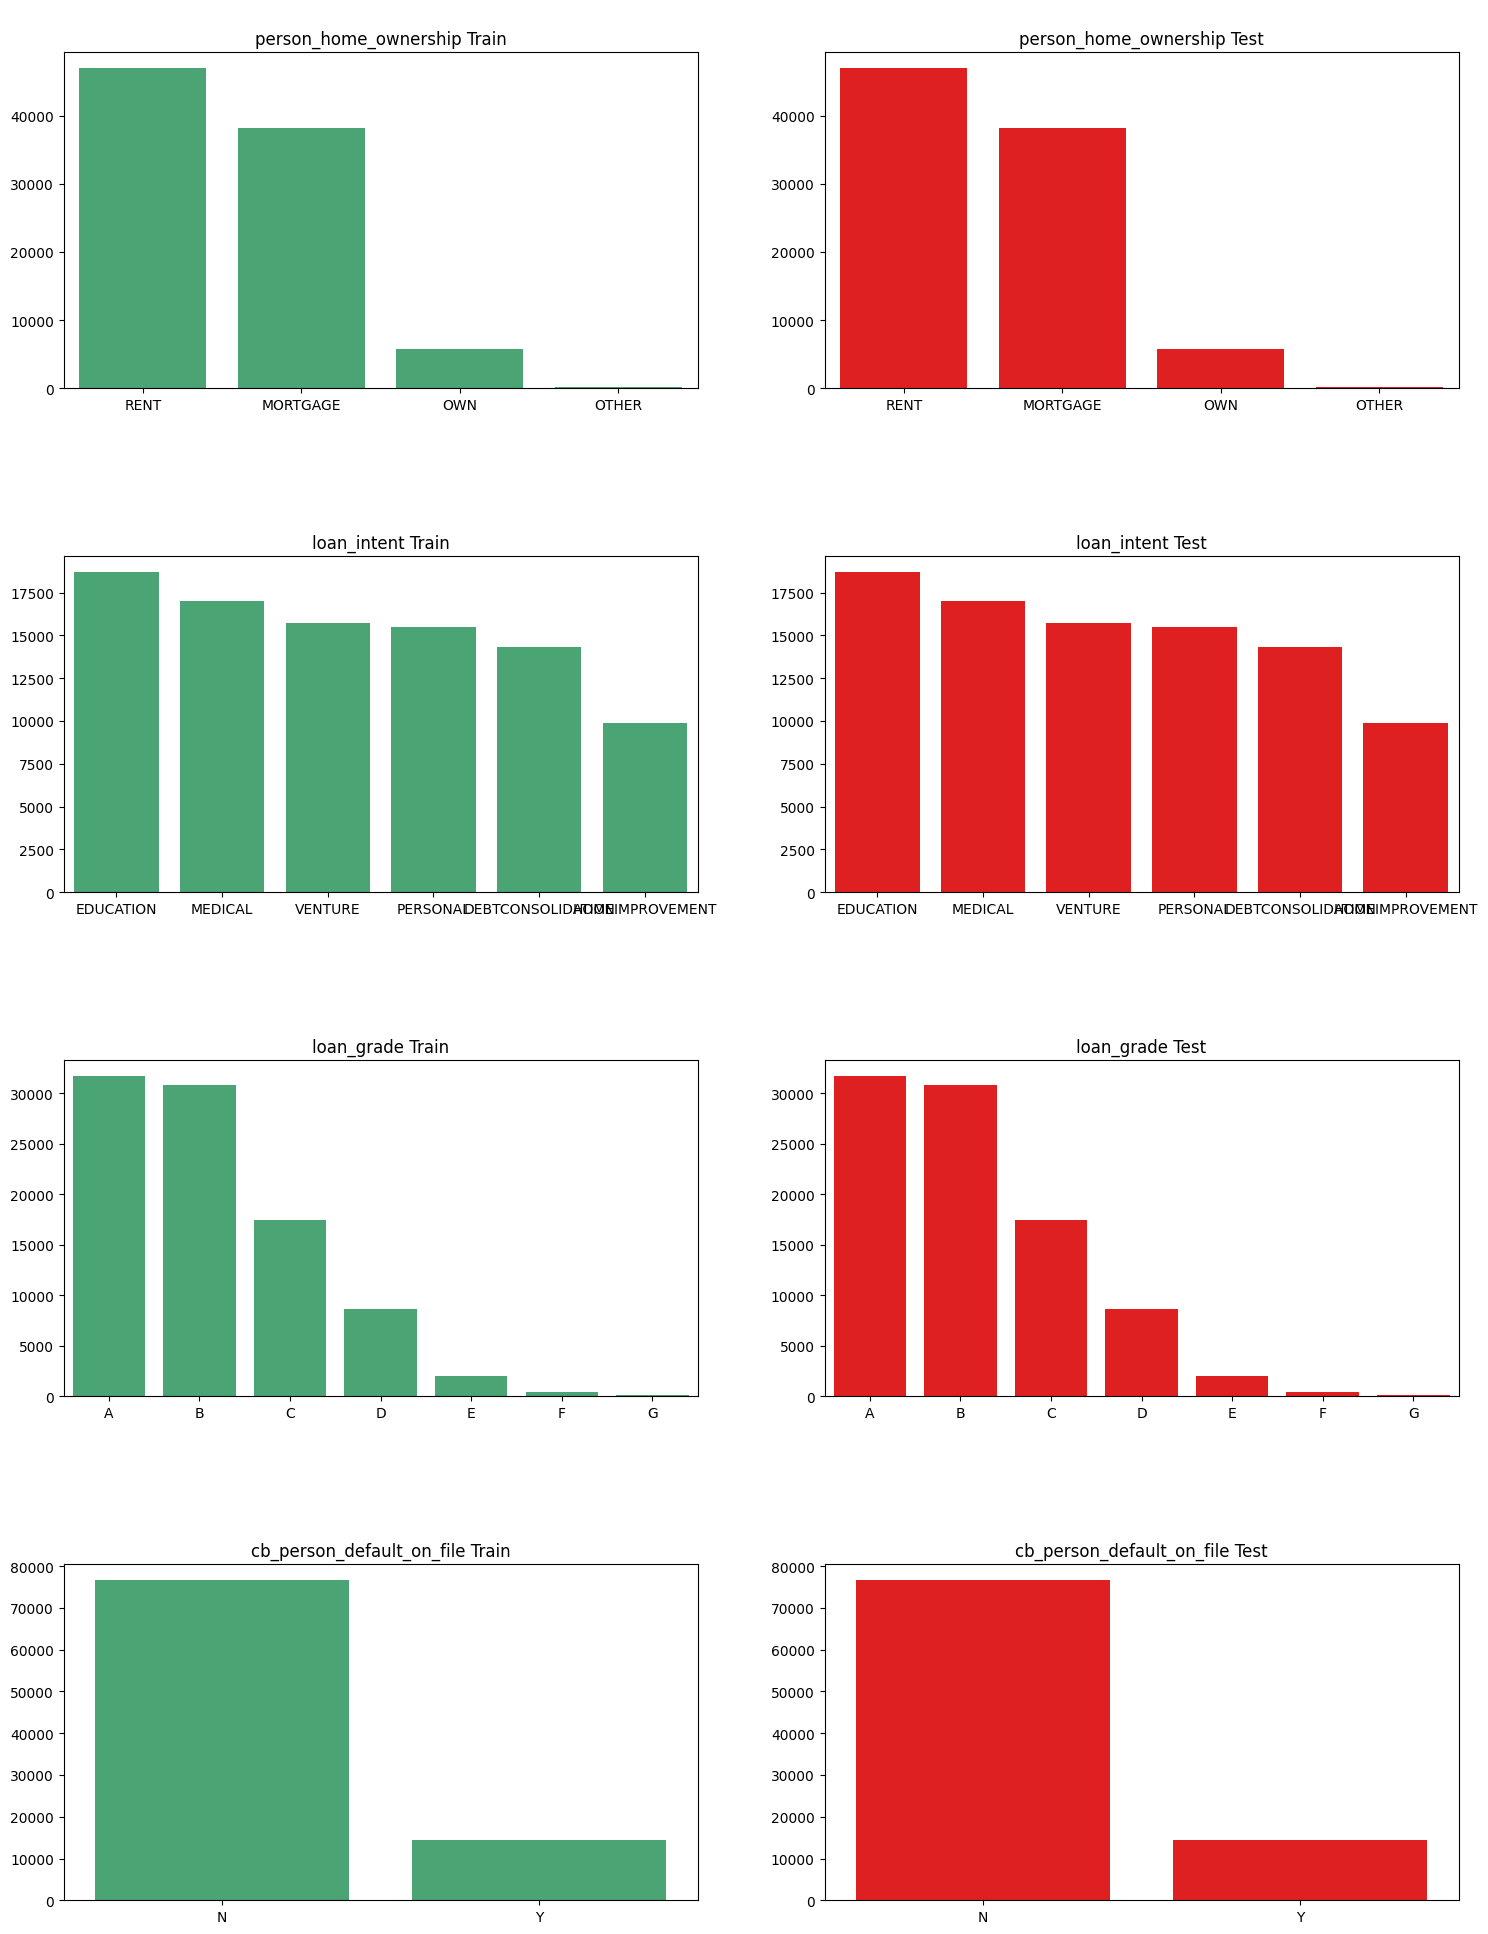


Target feature distribution



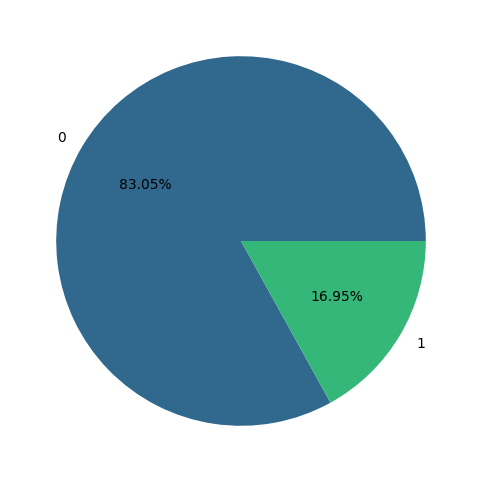

In [5]:
eda = EDA()

# Data Transformation

In [6]:
class Transform(Config, Preprocessing):
    
    def __init__(self):
        super().__init__()
        if self.missing == 'Y':
            self.missing_values()
            
        self.train_raw = self.train.copy()
        
        if self.feature_eng == 'Y':
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)
            
        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
            
        if self.outliers == 'Y':    
            self.remove_outliers()
            
        if self.log_trf == 'Y':
            self.log_transformation()
            
        if self.scaler_trf == 'Y':
            self.scaler()
            
        if self.outliers == 'Y' or self.log_trf == 'Y' or self.scaler_trf =='Y':
            self.distribution()
        
    def __call__(self):
        self.train[self.cat_features] = self.train[self.cat_features].astype('category')
        self.test[self.cat_features] = self.test[self.cat_features].astype('category')
        data = pd.concat([self.test, self.train])
        train_enc, test_enc = self.encode(data)

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(1 + data[f].max())
            
        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        train_enc = train_enc.drop(self.target, axis=1)
        
        scaler = StandardScaler()
        train_enc[self.num_features] = scaler.fit_transform(train_enc[self.num_features])
        test_enc[self.num_features] = scaler.transform(test_enc[self.num_features])
        
        return self.train, train_enc, self.y, self.test, test_enc, self.cat_features
    
    def encode(self, data):

        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype('int')
        
        train_enc = data[~data[self.target].isna()]
        test_enc = data[data[self.target].isna()].drop(self.target, axis=1)
        return train_enc, test_enc
            
    def new_features(self, df):
        df['loan_to_income'] = (df['loan_amnt'] / df['person_income']) - df['loan_percent_income']
        df = df[df['person_age']<100]
        df = df[df['person_income']<=1900000]
        df = df[df['person_emp_length']<50]
        df.reset_index(drop=True, inplace=True)

        return df

    def log_transformation(self):
         
        self.train[self.num_features] = np.log1p(self.train[self.num_features])
        self.test[self.num_features] = np.log1p(self.test[self.num_features])
        
        return self
    
    def distribution(self):

        print(Style.BRIGHT+Fore.GREEN+f'\nHistograms of distribution\n')
        fig, axes = plt.subplots(nrows=len(self.num_features), ncols=2, figsize=(15, len(self.num_features)*5))

        for (ax_r, ax_n), col in zip(axes, self.num_features):

            ax_r.set_title(f'{col} ($\mu=$ {self.train_raw[col].mean():.2f} and $\sigma=$ {self.train_raw[col].std():.2f} )')
            ax_r.hist(self.train_raw[col], bins=30, color='#3cb371')
            ax_r.axvline(self.train_raw[col].mean(), color='r', label='Mean')
            ax_r.axvline(self.train_raw[col].median(), color='y', linestyle='--', label='Median')
            ax_r.legend()

            ax_n.set_title(f'{col} Normalized ($\mu=$ {self.train[col].mean():.2f} and $\sigma=$ {self.train[col].std():.2f} )')
            ax_n.hist(self.train[col], bins=30, color='#3cb371')
            ax_n.axvline(self.train[col].mean(), color='r', label='Mean')
            ax_n.axvline(self.train[col].median(), color='y', linestyle='--', label='Median')
            ax_n.legend()
        
    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        self.train = self.train[(self.train[self.targets] >= lower_limit) & (self.train[self.targets] <= upper_limit)]
        self.train.reset_index(drop=True, inplace=True) 
        
    def scaler(self):
        scaler = StandardScaler()
        self.train[self.num_features] = scaler.fit_transform(self.train[self.num_features])
        self.test[self.num_features] = scaler.transform(self.test[self.num_features])
        return self
    
    def missing_values(self):
        
        self.train[self.num_features] = self.train[self.num_features].fillna(self.train[self.num_features].median())
        self.test[self.num_features] = self.test[self.num_features].fillna(self.test[self.num_features].median())  
        self.train[self.cat_features] = self.train[self.cat_features].fillna('None')
        self.test[self.cat_features] = self.test[self.cat_features].fillna('None')
        return self


Histograms of distribution



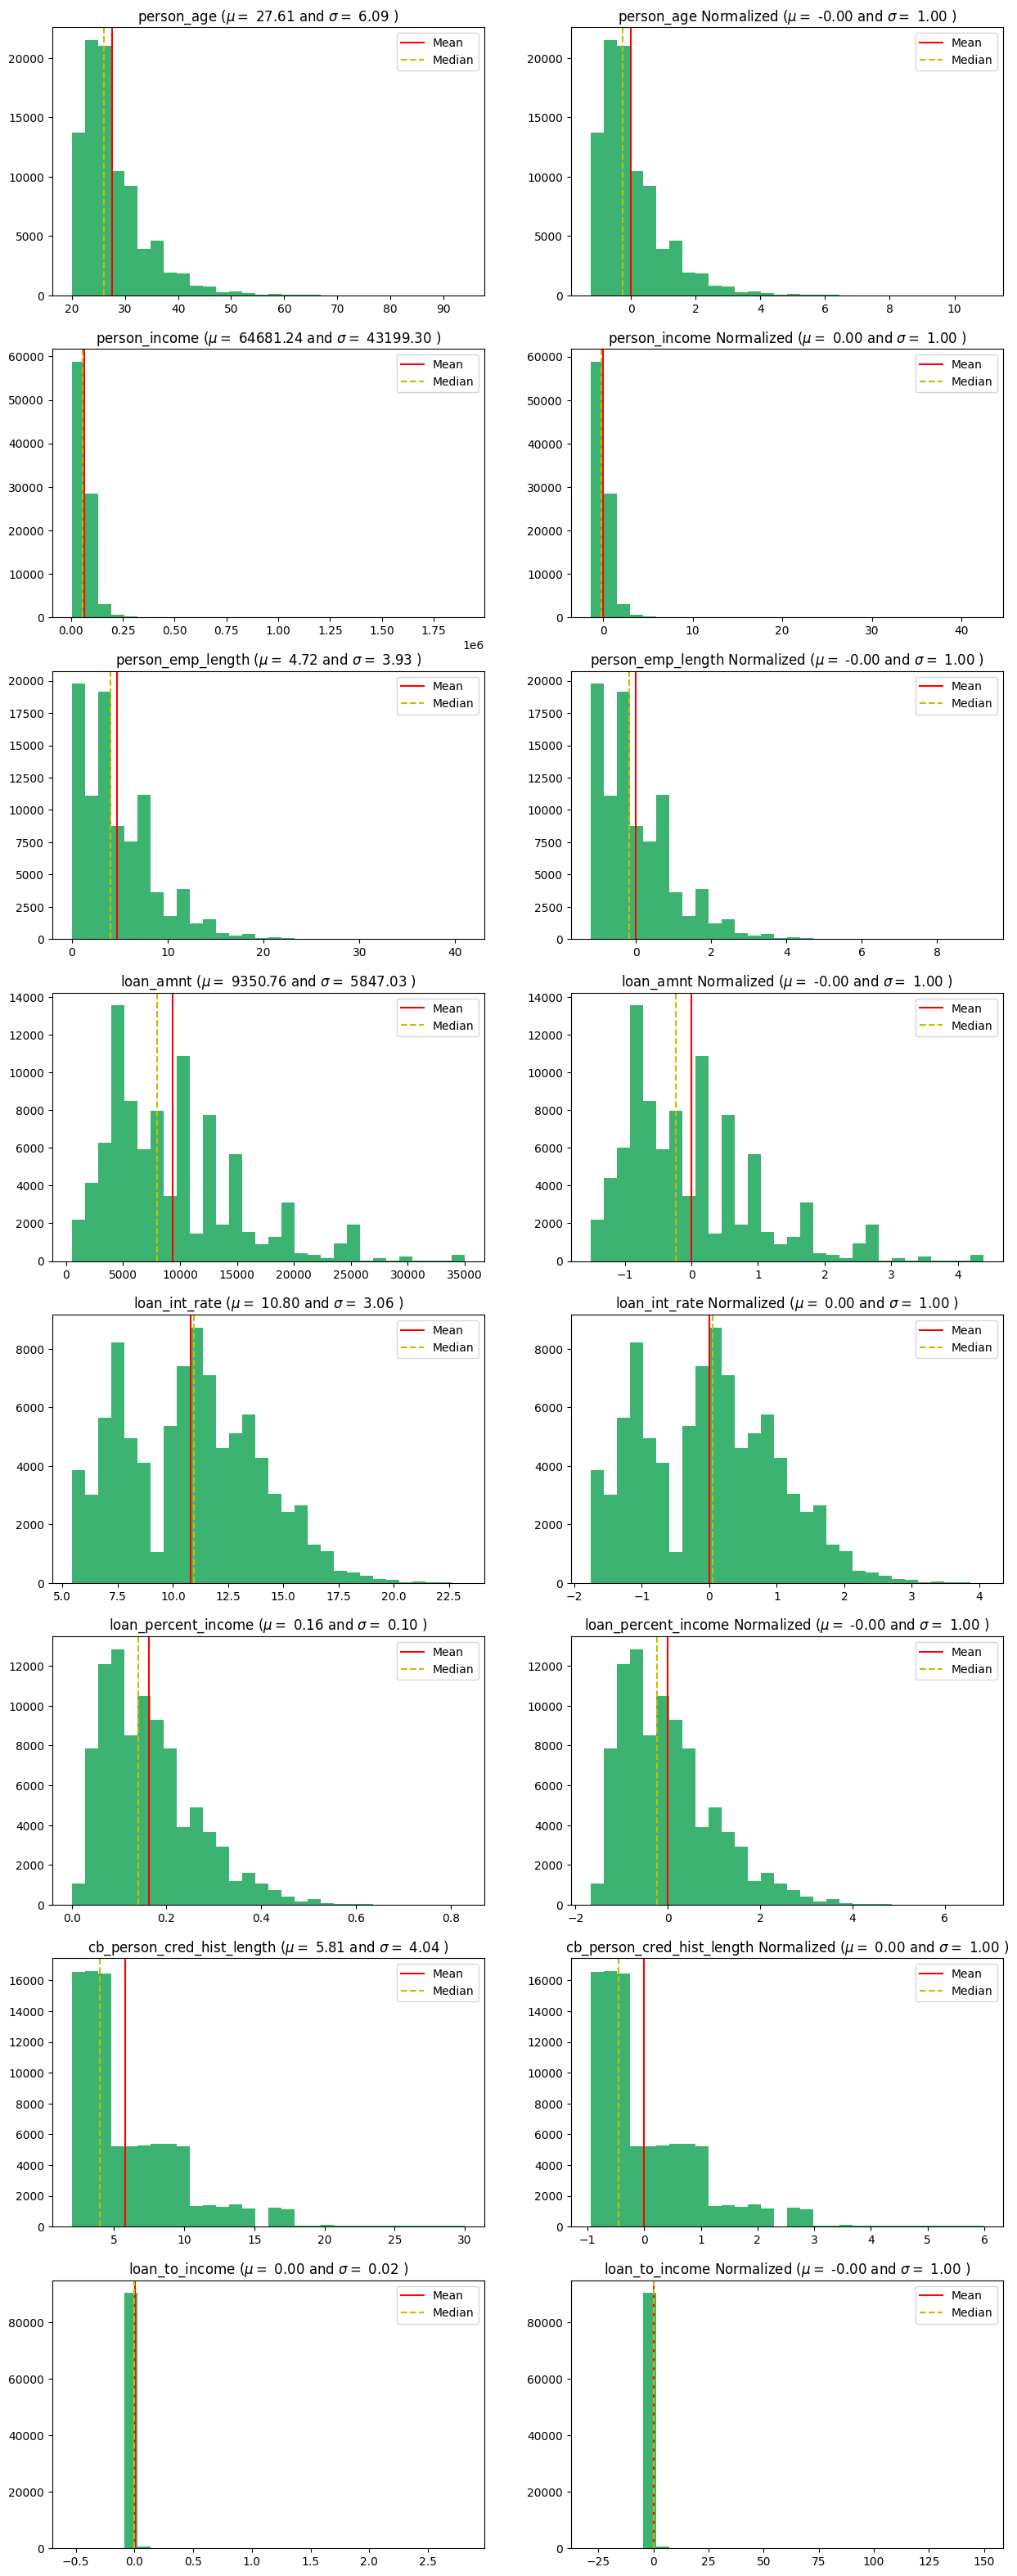

In [7]:
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()

# Model Training

**To balance classes, use the parameter class_weight="balanced"**

In [8]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

sample_pos_weight = class_weights[1]/class_weights[0]

In [9]:
def build_model():
    
    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(t.cat_features_card[j], int(np.ceil(np.sqrt(t.cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)
        
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    
    x = layers.Concatenate(axis=-1)(embs+[x_input_nums]) 
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

In [10]:
models = {
    'NN3': [build_model(),
       False],
    'XGB': [XGBClassifier(**{'tree_method': "hist",
                             'objective': 'binary:logistic',
                             'eval_metric': "auc",
                             'random_state': Config.state,
                             'early_stopping_rounds': Config.early_stop,
                             'verbosity': 0,
                             'enable_categorical': True,
                             'n_estimators': 5000,
                             'sample_pos_weight': sample_pos_weight,
                             'lambda': 0.1883884311989259,
                             'alpha': 0.5295235889266215,
                             'colsample_bytree': 0.5046530806015046,
                             'subsample': 0.8783114130443765,
                             'learning_rate': 0.03966832140995476,
                             'max_depth': 6,
                             'min_child_weight': 1
                         }),
            False],
    'XGB2': [XGBClassifier(**{'tree_method': "hist",
                              'objective': 'binary:logistic',
                              'eval_metric': "auc",
                              'random_state': Config.state,
                              'early_stopping_rounds': Config.early_stop,
                              'verbosity': 0,
                              'enable_categorical': True,
                              'n_estimators': 5000,
                              'sample_pos_weight': sample_pos_weight,
                              'lambda': 1.1720803271076492,
                              'alpha': 0.7896281471818399,
                              'colsample_bytree': 0.5013066226982371, 
                              'learning_rate': 0.015045676127187976,
                              'max_depth': 8,
                              'min_child_weight': 2,
                     }),
        False],
    'XGB3': [XGBClassifier(**{'tree_method': "hist",
                              'objective': 'binary:logistic',
                              'eval_metric': "auc",
                              'random_state': Config.state,
                              'early_stopping_rounds': Config.early_stop,
                              'verbosity': 0,
                              'enable_categorical': True,
                              'n_estimators': 5000,
                              'sample_pos_weight': sample_pos_weight,
                              'lambda': 5.138420646828161,
                              'alpha': 0.19245308685934964,
                              'colsample_bytree': 0.49744646519759944,
                              'subsample': 0.9637835134641782,
                              'learning_rate': 0.03301620020393856,
                              'max_depth': 9, 
                              'min_child_weight': 1 
                             }),
            False],
    'XGB4': [XGBClassifier(**{'tree_method': "hist",
                              'objective': 'binary:logistic',
                              'eval_metric': "auc",
                              'random_state': Config.state,
                              'early_stopping_rounds': Config.early_stop,
                              'verbosity': 0,
                              'enable_categorical': True,
                              'n_estimators': 5000,
                              'sample_pos_weight': sample_pos_weight,
                              'lambda': 4.513971594758926,
                              'alpha': 1.7611316688753071,
                              'colsample_bytree': 0.7659591609367851,
                              'subsample': 0.9815427409107734,
                              'learning_rate': 0.02343798614773425,
                              'max_depth': 10,
                              'min_child_weight': 1
                             }),
             False],
    'XGB5': [XGBClassifier(**{'tree_method': "hist",
                              'objective': 'binary:logistic',
                              'eval_metric': "auc",
                              'random_state': Config.state,
                              'early_stopping_rounds': Config.early_stop,
                              'verbosity': 0,
                              'enable_categorical': True,
                              'n_estimators': 5000,
                              'sample_pos_weight': sample_pos_weight,
                              'lambda': 1.8871009656946207,
                              'alpha': 0.4181134012483599,
                              'colsample_bytree': 0.6882951066747875,
                              'subsample': 0.8901954489827631,
                              'learning_rate': 0.005063346208994771, 
                              'max_depth': 17,
                              'min_child_weight': 1
                             }),
             False],
    'XGB6': [XGBClassifier(**{'tree_method': "hist",
                              'objective': 'binary:logistic',
                              'eval_metric': "auc",
                              'random_state': Config.state,
                              'early_stopping_rounds': Config.early_stop,
                              'verbosity': 0,
                              'enable_categorical': True,
                              'n_estimators': 5000,
                              'sample_pos_weight': sample_pos_weight,
                              'lambda': 1.8871009656946207, 
                              'alpha': 0.4181134012483599,
                              'colsample_bytree': 0.6882951066747875,
                              'subsample': 0.8901954489827631,
                              'learning_rate': 0.005063346208994771,
                              'max_depth': 17,
                              'min_child_weight': 1
                         }),
         False],
    'XGB7': [XGBClassifier(**{'tree_method': "hist",
                              'objective': 'binary:logistic',
                              'eval_metric': "auc",
                              'random_state': Config.state,
                              'early_stopping_rounds': Config.early_stop,
                              'verbosity': 0,
                              'enable_categorical': True,
                              'n_estimators': 5000,
                              'sample_pos_weight': sample_pos_weight,
                              'lambda': 3.867349368945961, 
                              'alpha': 0.7357296613855125, 
                              'colsample_bytree': 0.6226530915668331,
                              'learning_rate': 0.007790603328031136,
                              'max_depth': 10,
                              'max_bin': 15000
                             }),
            False],
    'XGB8': [XGBClassifier(**{'tree_method': "hist",
                              'objective': 'binary:logistic',
                              'eval_metric': "auc",
                              'random_state': Config.state,
                              'early_stopping_rounds': Config.early_stop,
                              'verbosity': 0,
                              'enable_categorical': True,
                              'n_estimators': 5000,
                              'sample_pos_weight': sample_pos_weight,
                              'lambda': 5.554210442144666, 
                              'alpha': 0.4842074370446999,
                              'colsample_bytree': 0.6187094431587342,
                              'learning_rate': 0.004381482135782534,
                              'max_depth': 12,
                              'max_bin': 15000
                             }),
            False],
    'LGBM': [LGBMClassifier(**{'objective': 'binary',
                               'metric': "auc",
                               'random_state': Config.state,
                               'categorical_feature': cat_features,
                               'early_stopping_round': Config.early_stop,
                               'verbosity': -1,
                               'n_estimators': 5000,
                               'sample_pos_weight': sample_pos_weight,
                               'max_depth': 10,
                               'learning_rate': 0.011918021820526493,
                               'min_child_weight': 2.182953291491315,
                               'min_child_samples': 31,
                               'subsample': 0.8949299413377961,
                               'subsample_freq': 4, 
                               'colsample_bytree': 0.5500996159158312,
                               'num_leaves': 67, 
                               'reg_lambda': 2.7797582116130166,
                               'max_bin': 15000
                              }),
             False],
    'LGBM2': [LGBMClassifier(**{'objective': 'binary',
                                'metric': "auc",
                                'random_state': Config.state,
                                'categorical_feature': cat_features,
                                'early_stopping_round': Config.early_stop,
                                'verbosity': -1,
                                'n_estimators': 5000,
                                'sample_pos_weight': sample_pos_weight,
                                'max_depth': 8,
                                'learning_rate': 0.014147476894063768,
                                'min_child_weight': 0.9990097430230203,
                                'min_child_samples': 34,
                                'subsample': 0.8027641883715668,
                                'colsample_bytree': 0.512323827173708,
                                'num_leaves': 382,
                                'reg_lambda': 2.6885602614884228,
                                'max_bin': 15000
                              }),
             False],
    'LGBM3': [LGBMClassifier(**{'objective': 'binary',
                                'metric': "auc",
                                'random_state': Config.state,
                                'categorical_feature': cat_features,
                                'early_stopping_round': Config.early_stop,
                                'verbosity': -1,
                                'n_estimators': 5000,
                                'sample_pos_weight': sample_pos_weight,
                                'max_depth': 16,
                                'learning_rate': 0.011927368517646378,
                                'min_child_weight': 0.682278871121153,
                                'min_child_samples': 17,
                                'subsample': 0.9724252492274816,
                                'subsample_freq': 5,
                                'colsample_bytree': 0.5583454077344532,
                                'num_leaves': 87,
                                'reg_lambda': 2.066143634052782,
                                'max_bin': 15000
                                }),
             False],
    'LGBM4': [LGBMClassifier(**{'objective': 'binary',
                                'metric': "auc",
                                'random_state': Config.state,
                                'categorical_feature': cat_features,
                                'early_stopping_round': Config.early_stop,
                                'verbosity': -1,
                                'n_estimators': 5000,
                                'sample_pos_weight': sample_pos_weight,
                                'max_depth': 12,
                                'learning_rate': 0.018332392084265986,
                                'min_child_weight': 1.9786219523267656,
                                'min_child_samples': 54,
                                'subsample': 0.9803863161726395, 
                                'colsample_bytree': 0.5077423604403928,
                                'num_leaves': 58,
                                'reg_lambda': 8.484313739624909,
                                'max_bin': 15000
                                }),
             False],
    'LGBM5': [LGBMClassifier(**{'objective': 'binary',
                                'metric': "auc",
                                'random_state': Config.state,
                                'categorical_feature': cat_features,
                                'early_stopping_round': Config.early_stop,
                                'verbosity': -1,
                                'n_estimators': 5000,
                                'sample_pos_weight': sample_pos_weight,
                                'max_depth': 15,
                                'learning_rate': 0.02427880819727122, 
                                'min_child_weight': 3.2215434995203176,
                                'min_child_samples': 9,
                                'subsample': 0.28121008578102613,
                                'colsample_bytree': 0.4866288405757808,
                                'num_leaves': 61,
                                'reg_lambda': 5.440995549868447,
                                'min_data_in_leaf': 58,
                                'max_bin': 15000
                              }),
             False],
    'LGBM6': [LGBMClassifier(**{'objective': 'binary',
                                'metric': "auc",
                                'random_state': Config.state,
                                'categorical_feature': cat_features,
                                'early_stopping_round': Config.early_stop,
                                'verbosity': -1,
                                'n_estimators': 5000,
                                'sample_pos_weight': sample_pos_weight,
                                'max_depth': 18, 
                                'learning_rate': 0.015648935287639748,
                                'min_child_weight': 0.8151026538460138, 
                                'min_child_samples': 24,
                                'subsample': 0.2796470942954887,
                                'colsample_bytree': 0.6092855563731399,
                                'num_leaves': 84,
                                'reg_lambda': 3.641728867952662,
                                'max_bin': 15000
                          }),
             False],
    "CAT": [CatBoostClassifier(**{'objective': 'Logloss',
                                  'eval_metric': "AUC",
                                  'verbose': 0,
                                  'random_state': Config.state,
                                  'early_stopping_rounds': Config.early_stop,
                                  'cat_features': cat_features,
                                  'n_estimators': 5000,
                                  'scale_pos_weight': sample_pos_weight,
                                  'loss_function': 'Logloss',
                                  'learning_rate': 0.08114394459649094,
                                  'depth': 6,
                                  'random_strength':0,
                                  'l2_leaf_reg': 0.7047064221215757,
                                  'verbose':False
                                }),
           False],
    "CAT2": [CatBoostClassifier(**{'objective': 'Logloss',
                                   'eval_metric': "AUC",
                                   'verbose': 0,
                                   'random_state': Config.state,
                                   'early_stopping_rounds': Config.early_stop,
                                   'cat_features': cat_features,
                                   'n_estimators': 5000,
                                   'scale_pos_weight': sample_pos_weight,
                                   'learning_rate': 0.057695680893866355,
                                   'l2_leaf_reg': 8.718243448685213,
                                   'bagging_temperature': 15.939315101482947,
                                   'random_strength': 1.2951116775412417,
                                   'depth': 5,
                                   'min_data_in_leaf': 65 
                                }),
           False],
    "CAT3": [CatBoostClassifier(**{'objective': 'Logloss',
                                   'eval_metric': "AUC",
                                   'verbose': 0,
                                   'random_state': Config.state,
                                   'early_stopping_rounds': Config.early_stop,
                                   'cat_features': cat_features,
                                   'n_estimators': 5000,
                                   'scale_pos_weight': sample_pos_weight,
                                   'learning_rate': 0.08746007467982597,
                                   'l2_leaf_reg': 3.50212953568363,
                                   'bagging_temperature': 0.15909129439715475,
                                   'random_strength': 1.6930893184821436,
                                   'depth': 4, 
                                   'min_data_in_leaf': 203,
                                   'grow_policy': 'SymmetricTree',
                                   'boosting_type': 'Plain',
                                }),
           False],
    "CAT4": [CatBoostClassifier(**{'objective': 'Logloss',
                                   'eval_metric': "AUC",
                                   'verbose': 0,
                                   'random_state': Config.state,
                                   'early_stopping_rounds': Config.early_stop,
                                   'cat_features': cat_features,
                                   'n_estimators': 2000,
                                   'scale_pos_weight': sample_pos_weight,
                                   'learning_rate': 0.023100406276723946,
                                   'l2_leaf_reg': 0.14310494715158462,
                                   'bagging_temperature': 0.8747439645420433,
                                   'random_strength': 1.0600863564781058,
                                   'depth': 4,
                                   'min_data_in_leaf': 67,
                                   'grow_policy': 'SymmetricTree',
                                   'boosting_type': 'Plain',
                                    }),
           False],
    "CAT5": [CatBoostClassifier(**{'objective': 'Logloss',
                                   'eval_metric': "AUC",
                                   'verbose': 0,
                                   'random_state': Config.state,
                                   'early_stopping_rounds': Config.early_stop,
                                   'cat_features': cat_features,
                                   'n_estimators': 2000,
                                   'scale_pos_weight': sample_pos_weight,
                                   'learning_rate': 0.023100406276723946,
                                   'l2_leaf_reg': 0.14310494715158462,
                                   'bagging_temperature': 0.8747439645420433,
                                   'random_strength': 1.0600863564781058,
                                   'depth': 4,
                                   'min_data_in_leaf': 67,
                                   'grow_policy': 'SymmetricTree',
                                   'boosting_type': 'Plain',
                                }),
           False],
    "CAT6": [CatBoostClassifier(**{'early_stopping_rounds': Config.early_stop,
                                   'loss_function': 'Logloss',
                                   'eval_metric': "AUC",
                                   'bagging_temperature': 0.25,
                                   'colsample_bylevel': 0.40,
                                   'iterations': 5000,
                                   'learning_rate': 0.045,
                                   'max_depth': 7,
                                   'l2_leaf_reg': 0.80,
                                   'min_data_in_leaf': 30,
                                   'random_strength': 0.25,
                                   'verbose': 0,
                                   'cat_features': cat_features,
                                   'scale_pos_weight': sample_pos_weight,
                                   'random_state': Config.state,
                                 }),
             False],
    "CAT7": [CatBoostClassifier(**{'learning_rate': 0.019914086642922255,
                                   'l2_leaf_reg': 0.5965527914059113,
                                   'bagging_temperature': 0.21414550710980085,
                                   'random_strength': 0.528432916293001,
                                   'depth': 5,
                                   'min_data_in_leaf': 132,
                                   'objective': 'Logloss',
                                   'eval_metric': "AUC",
                                   'verbose': 0,
                                   'random_state': Config.state,
                                   'early_stopping_rounds': Config.early_stop,
                                   'cat_features': cat_features,
                                   'n_estimators': 5000,
                                   'scale_pos_weight': sample_pos_weight,
                                  }),
             False],
    "CAT8": [CatBoostClassifier(**{'learning_rate': 0.09964585918770091,
                                   'l2_leaf_reg': 9.213583120085929,
                                   'bagging_temperature': 0.8971667774741543, 
                                   'random_strength': 1.3413807743378525,
                                   'depth': 7,
                                   'min_data_in_leaf': 64,
                                   'cat_features': cat_features,
                                   'scale_pos_weight': sample_pos_weight,
                                   'random_state': Config.state,
                                   'early_stopping_rounds': Config.early_stop,
                                   'loss_function': 'Logloss',
                                   'eval_metric': "AUC",
                                   'n_estimators': 5000,
                                  }),
             False],
    "CAT9": [CatBoostClassifier(**{'learning_rate': 0.029375245355338864,
                                   'l2_leaf_reg': 5.606401682614865,
                                   'bagging_temperature': 0.10279123124679676,
                                   'random_strength': 0.33545896157753763,
                                   'depth': 7,
                                   'min_data_in_leaf': 189,
                                   'cat_features': cat_features,
                                   'scale_pos_weight': sample_pos_weight,
                                   'random_state': Config.state,
                                   'early_stopping_rounds': Config.early_stop,
                                   'loss_function': 'Logloss',
                                   'eval_metric': "AUC",
                                   'n_estimators': 5000,
                                   'grow_policy': 'SymmetricTree',
                                   'boosting_type': 'Plain',
                                  }),
             False],
    "CAT10": [CatBoostClassifier(**{'learning_rate': 0.05624354520782216,
                                    'l2_leaf_reg': 8.574301382348253,
                                    'bagging_temperature': 0.18124654280594427,
                                    'random_strength': 0.1134966757407917,
                                    'depth': 5,
                                    'min_data_in_leaf': 146,
                                    'cat_features': cat_features,
                                    'scale_pos_weight': sample_pos_weight,
                                    'random_state': Config.state,
                                    'early_stopping_rounds': Config.early_stop,
                                    'loss_function': 'Logloss',
                                    'eval_metric': "AUC",
                                    'n_estimators': 5000,
                                    'grow_policy': 'SymmetricTree',
                                    'boosting_type': 'Plain',
                                   }),
              False],
}

In [11]:
class Model(Config):
    
    def __init__(self, X, X_enc, y, test, test_enc, models):
        self.y = y
        self.models = models
        self.scores = pd.DataFrame(columns=['Score'])
        self.OOF_preds = pd.DataFrame()
        
    def train(self):
        
        folds = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.state)

        TEST_preds = pd.DataFrame()
        
        for model_name, [model, training] in tqdm(self.models.items()):
            
            if training:
                print('='*20)
                print(model_name)
                if any(model in model_name for model in ['LGBM', 'CAT', 'XGB']):
                    self.X = X
                    self.test = test
 
                else:
                    self.X = X_enc
                    self.test = test_enc
                    
                if 'NN' in model_name:
                    for n_fold, (train_id, valid_id) in enumerate(folds.split(self.X, self.y)):

                        X_train_cats = self.X.loc[train_id, cat_features]
                        X_train_nums = self.X.loc[train_id, t.num_features]
                        y_train = self.y.loc[train_id].values

                        X_val_cats = self.X.loc[valid_id, cat_features]
                        X_val_nums = self.X.loc[valid_id, t.num_features]
                        y_val = self.y.loc[valid_id]

                        X_test_cats = self.test[cat_features]
                        X_test_nums = self.test[t.num_features]
        
                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val_cats.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')
                                                
                        keras.utils.set_random_seed(self.state)
                        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
                        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
                        model.fit([X_train_cats,X_train_nums], y_train, 
                                  validation_data=([X_val_cats, X_val_nums], y_val),
                                  epochs=20,
                                  batch_size=1000,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=1),
                                             keras.callbacks.EarlyStopping(patience=3)
                                            ])
                        
                        y_pred_val = model.predict([X_val_cats, X_val_nums])
                        test_pred = model.predict([X_test_cats, X_test_nums])
                        
                        score = roc_auc_score(y_val, y_pred_val)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score
                        
                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred

                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        TEST_preds = pd.concat([TEST_preds, test_preds], axis = 0, ignore_index = False)
                        
                else:
                    for n_fold, (train_id, valid_id) in enumerate(folds.split(self.X, self.y)):
                        X_train, y_train = self.X.iloc[train_id], self.y.iloc[train_id]
                        X_val, y_val = self.X.iloc[valid_id], self.y.iloc[valid_id]

                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if "XGB" in model_name:
                            model.fit(X_train, y_train, 
                                      eval_set = [(X_val, y_val)], 
                                      verbose = False
                                     )

                        elif "CAT" in model_name:
                            model.fit(X_train, y_train, 
                                      eval_set = [(X_val, y_val)],
                                      verbose=False
                                      ) 

                        elif "LGBM" in model_name:
                             model.fit(X_train, y_train, 
                                       eval_set = [(X_val, y_val)], 
                                       callbacks = [log_evaluation(0),
                                                    early_stopping(self.early_stop, verbose = False)
                                                   ])  

                        else:
                            model.fit(X_train, y_train)


                        y_pred_val = model.predict_proba(X_val)[:, 1]
                        test_pred = model.predict_proba(self.test)[:, 1]
                        
                        score = roc_auc_score(y_val, y_pred_val)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred

                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        TEST_preds = pd.concat([TEST_preds, test_preds], axis = 0, ignore_index = False)

                self.OOF_preds = self.OOF_preds.groupby(level=0).mean()
                TEST_preds = TEST_preds.groupby(level=0).mean()

                self.OOF_preds[f'{model_name}'].to_csv(f'{model_name}_oof.csv', index=False)
                TEST_preds[f'{model_name}'].to_csv(f'{model_name}_test.csv', index=False)
            
            else:
                self.OOF_preds[f'{model_name}'] = pd.read_csv(f'/kaggle/input/loan-approval-models/{model_name}_oof.csv')
                TEST_preds[f'{model_name}'] = pd.read_csv(f'/kaggle/input/loan-approval-models/{model_name}_test.csv')
                
                for n_fold, (train_id, valid_id) in enumerate(folds.split(self.OOF_preds[f'{model_name}'], self.y)):
                    y_pred_val, y_val = self.OOF_preds[f'{model_name}'].iloc[valid_id], self.y.iloc[valid_id]
                    self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = roc_auc_score(y_val, y_pred_val)
                    
            self.scores.loc[f'{model_name}', 'Score'] = self.scores.loc[f'{model_name}'][1:].mean()
        self.scores.loc['Ensemble'], self.OOF_preds["Ensemble"], TEST_preds["Ensemble"] = self.ensemble(self.OOF_preds, self.y, TEST_preds)
        self.scores = self.scores.sort_values('Score')

        self.result()

        return TEST_preds
    
    def best_threshold(self, y_true, y_pred):
        thresholds = np.linspace(0.01, 0.99, 50)
        self.mcc = np.array([roc_auc_score(y_true, y_pred>thr) for thr in thresholds])
        best_threshold = thresholds[self.mcc.argmax()]
        return best_threshold 
    
    def ensemble(self, X, y, test):
        scores = []
        oof_pred = np.zeros(X.shape[0])
        test_pred = np.zeros(test.shape[0])
        model = LogisticRegression(C = 0.10, random_state = self.state, max_iter = 5000)
        skf = StratifiedKFold(n_splits=self.n_splits, random_state=self.state, shuffle=True)

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)

            y_pred_probs = model.predict_proba(X_val)[:, 1]
            oof_pred[val_idx] = y_pred_probs
            test_pred += model.predict_proba(test)[:, 1] / self.n_splits
            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
          
        return np.mean(scores), oof_pred, test_pred
    
    def result(self):
               
        plt.figure(figsize=(18, 6))
        hbars = plt.bar(self.scores.index, self.scores.Score, color='#3cb371', width=0.6)
        plt.bar_label(hbars, fmt='%.4f')
        plt.ylim(0.9, 0.98)
        plt.ylabel('Models')
        plt.xlabel('Score')                       
        plt.show()
                                                                                                                                                        
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))
        for model in self.OOF_preds[list(self.models.keys()) + ['Ensemble']]:
            RocCurveDisplay.from_predictions(y.sort_index(), self.OOF_preds[model], ax=axes[0], name=model)

        axes[0].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC')
        axes[0].legend(loc="lower right")

        ConfusionMatrixDisplay.from_predictions(y, (self.OOF_preds['Ensemble']>=0.5).astype(int), display_labels=[0, 1], colorbar=False, ax=axes[1], cmap = 'Greens')
        axes[1].set_title('Confusion Matrix')

        plt.tight_layout()
        plt.show()

In [12]:
trained = pd.read_csv('/kaggle/input/loan-approval-ensemble-nn-xgb-lgbm-cat/submission.csv')

# Submission Time

In [13]:
submission = Config.submission
submission[Config.target] = trained['loan_status']
submission.to_csv("submission.csv", index=False)

display(submission.head())

,id,loan_status
0,58645,0.976651
1,58646,0.014881
2,58647,0.648862
3,58648,0.012788
4,58649,0.035643


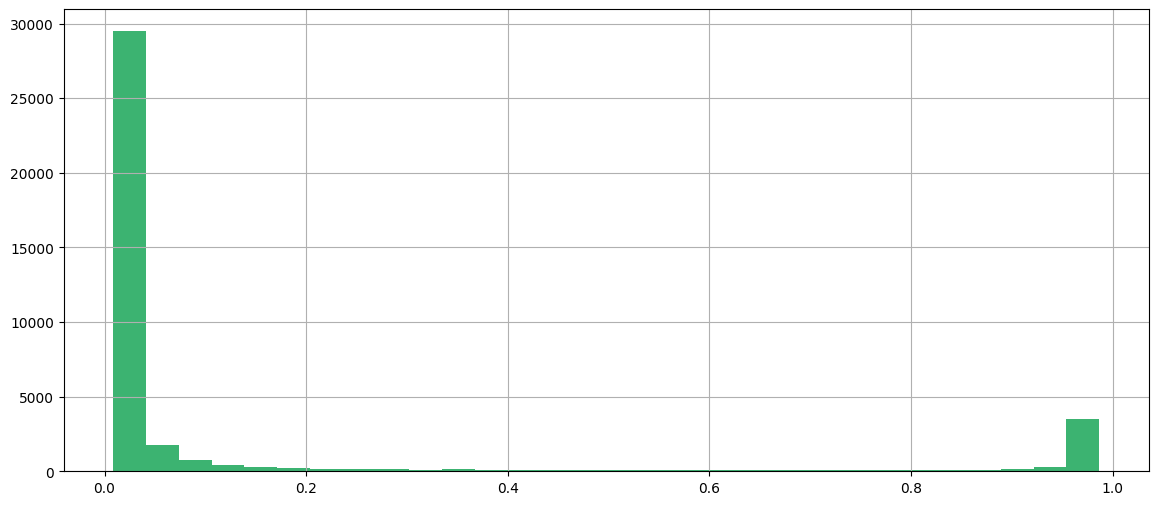

In [14]:
plt.figure(figsize=(14, 6))
submission[Config.target].hist(color='#3cb371', bins=30)
plt.show()